# Crop-Land Allocation in integrated crop-livestock systems (ICLS)

### MGSC 662 - Decision Analytics taught by Prof. Javad Nasiry

##### Co-Authors : Hugo Guideau, Al Cheaito, Vasilis Christopoulos, Tirth Baldia, Rafael Chantres

In [2]:
import gurobipy as gb
from gurobipy import *
import numpy as np
import pandas as pd
from random import random

We add p in J for the pastures.

$$ Q_{n, p_s, l_r, k} = x_{p_s, l_r}^k \times S_s \times (n(Up)_l - n(Up)_p + n(Re)_p - \alpha \times m_n \times \rho) $$

Constraint on having each Q superior to 0 to make it realistic:

$$ Q_{n, j_s, l_r, k} > 0 $$

Constraint on the number of cows:

$$ \sum_{s \in S, l \in J, r \in S} x_{p_s, l_r}^k \times S_s \times \rho \leq C_i $$

In [4]:
# Define the data

J = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Crops = [
    "Spring Wheat",
    "Winter Wheat",
    "Barley",
    "Oats",
    "Rye",
    "Corn",
    "Canola",
    "Soybeans",
    "Peas",
    "Lentils",
    "Grass",
    "Corn Silage",
    "Pasture",
]
K = [0, 1, 2, 3, 4, 5]

# Crop needs

uptake = [
    [85, 32, 73, 9],     # Spring Wheat
    [67, 30, 70, 10],    # Winter Wheat
    [111, 45, 106, 13],  # Barley
    [116, 40, 145, 13],  # Oats
    [92, 45, 130, 15],   # Rye
    [153, 63, 128, 15],  # Corn
    [112, 52, 81, 19],   # Canola
    [180, 31, 129, 12],  # Soybeans
    [153, 43, 136, 12],  # Peas
    [92, 25, 76, 9],     # Lentils
    [102, 30, 130, 13],  # Grass
    [156, 63, 201, 13],  # Corn Silage
    [102, 30, 130, 13],  # Pasture
]

removal = [
    [60, 23, 18, 5],     # Spring Wheat
    [52, 25, 17, 7],     # Winter Wheat
    [77, 34, 26, 7],     # Barley
    [61, 25, 18, 5],     # Oats
    [58, 24, 20, 5],     # Rye
    [97, 44, 27, 6],     # Corn
    [68, 37, 18, 11],    # Canola
    [135, 29, 49, 4],    # Soybeans
    [117, 35, 35, 6],    # Peas
    [62, 18, 33, 5],     # Lentils
    [102, 30, 130, 13],  # Grass
    [156, 63, 201, 13],  # Corn Silage
    [102, 30, 130, 13],  # Pasture
]

rho = 1 / 1.62

mn = [69.9, 43.64, 75, 8.6]

alpha = 0.6

# Translate lb/acre to kg/ha

uptake = np.array(uptake) * 1.12085
removal = np.array(removal) * 1.12085

S = [0, 1, 2, 3, 4]

Surface = [0.32, 1.6, 9.28, 58, 200]

p = [0.04, 0.05, 0.19, 0.61, 0.11]

list_crops = [
    "BARLEY_M",
    "OTTAME_M",
    "CANOLA_M",
    "CORNGR_M",
    "CORNSI_M",
    "DFPEAS_M",
    "LENTIL_M",
    "OATS_M",
    "SOYBNS_M",
    "TOTRYE_M",
    "WHTSPG_M",
    "WHTWIN_M"
]

In [5]:
# Divide the areas with their respected fields

A = pd.read_csv("crop_alberta.csv", index_col="CCSUID")
A = A.drop(columns=["CCSNAME","SRUNOM"])
A = A.clip(lower=0)

# Change the name of the columns to match the Crops
A.columns = Crops[:len(J)-1]

CCSUID = A.index.tolist()

A.head()

,Spring Wheat,Winter Wheat,Barley,Oats,Rye,Corn,Canola,Soybeans,Peas,Lentils,Grass,Corn Silage
CCSUID,,,,,,,,,,,,
4801003,43167.0,0.0,20906.0,2091.0,1635.0,0.0,23237.0,0.0,20137.0,13778.0,10460.0,1631.0
4801008,63724.0,4846.0,40076.0,2946.0,2460.0,0.0,44214.0,0.0,31745.0,49957.0,3191.0,0.0
4802001,35461.0,8392.0,43327.0,1150.0,3287.0,0.0,43364.0,0.0,17465.0,28351.0,5208.0,7237.0
4802011,54277.0,9021.0,74324.0,3748.0,5972.0,4582.0,65286.0,553.0,17650.0,9572.0,10054.0,12679.0
4802021,44949.0,5216.0,28457.0,1146.0,0.0,5136.0,33353.0,0.0,12257.0,7899.0,4533.0,2937.0


In [6]:
# Divide the areas with their respected fields

C = pd.read_csv("cattle_alberta.csv", index_col="CCSUID")
C = C.drop(columns=["CCSNAME","SRUNOM"])
C = C.clip(lower=0)

CCSUID = C.index.tolist()

C.head()

,TOTCOW
CCSUID,
4801003,55225.0
4801008,22520.0
4802001,32439.0
4802011,36038.0
4802021,25134.0


In [7]:
# Implementation of the model

m = gb.Model("Crop-rotation Optimization - Number of Fields - Cattle integration")

Set parameter Username
Set parameter LicenseID to value 2704635
Academic license - for non-commercial use only - expires 2026-09-08


In [8]:
# Decision variables

x = m.addVars(
    [(ccs, j, s, l, r, k)
                        for ccs in CCSUID
                        for j in J
                        for s in S
                        for l in J
                        for r in S
                        for k in K],
    lb = 0,
    vtype=gb.GRB.CONTINUOUS,
    name=lambda tpl: f"x_{ccs}_{j}_{s}_{l}_{r}_{k}"
)

In [9]:
# Computation of the quantities of nutrients to bring

Q = {}
for ccs in CCSUID:
    for n in range(len(uptake[0])):
        for j in J:
            for s in S:
                for l in J:
                    for r in S:
                        for k in K:
                            if Crops[j] != 'Pasture':
                                Q[ccs, n, j, s, l, r, k] = x[ccs, j, s, l, r, k] * Surface[s] * (uptake[l][n] - uptake[j][n] + removal[j][n])
                            else:
                                Q[ccs, n, j, s, l, r, k] = x[ccs, j, s, l, r, k] * Surface[s] * (uptake[l][n] - uptake[j][n] + removal[j][n] - alpha * mn[n] * rho)


In [10]:
# Objective function

m.setObjective(sum(Q[ccs, n, j, s, l, r, k] for ccs in CCSUID for n in range(len(uptake[0])) for j in J for s in S for l in J for r in S for k in K), GRB.MINIMIZE)

In [11]:
# Add Constraints

m.addConstrs((sum(x[ccs, j, s, l, r, k] * Surface[s] for j in J for s in S for r in S) >= 0.8 * float(A.loc[ccs][Crops[l]]) for ccs in CCSUID for l in J[:len(J)-1] for k in K if Crops[l] != 'Grass'), name="Demand")
m.addConstrs((sum(x[ccs, j, s, 10, r, k] * Surface[s] + x[ccs, j, s, 12, r, k] * Surface[s] for j in J for s in S for r in S) >= 0.8 * float(A.loc[ccs][Crops[10]]) for ccs in CCSUID for k in K), name="Demand")
m.addConstrs((sum(x[ccs, j, s, l, r, k] * Surface[s] for j in J for s in S) == sum(x[ccs, l, r, j, s, k+1] * Surface[r] for j in J for s in S) for ccs in CCSUID for l in J for r in S for k in K[:len(K)-1]), name="Surface Conservation")
m.addConstrs((sum(x[ccs, j, s, l, r, len(K) - 1] * Surface[s] for j in J for s in S) == sum(x[ccs, l, r, j, s, 0] * Surface[r] for j in J for s in S) for ccs in CCSUID for l in J for r in S), name="Surface Conservation")
m.addConstrs((sum(x[ccs, j, s, l, r, k] for l in J for j in J for s in S) == p[r] * sum(x[ccs, j, s, l, r, k] for l in J for r in S for j in J for s in S) for ccs in CCSUID for r in S for k in K), name="Field Distribution")
m.addConstrs((sum(x[ccs, 12, s, l, r, k] * Surface[s] * rho for l in J for j in J for s in S) <= float(C.loc[ccs]) for ccs in CCSUID for l in J for r in S for s in S for k in K), name="Cattle Limit")
m.addConstrs(Q[ccs, n, j, s, l, r, k] >= 0 for ccs in CCSUID for n in range(len(uptake[0])) for j in J for s in S for l in J for r in S for k in K)

/var/folders/yr/qhnlkgj13nn63_0zptp9g1400000gn/T/ipykernel_94758/1339642365.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  m.addConstrs((sum(x[ccs, 12, s, l, r, k] * Surface[s] * rho for l in J for j in J for s in S) <= float(C.loc[ccs]) for ccs in CCSUID for l in J for r in S for s in S for k in K), name="Cattle Limit")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{(4801003, 0, 0, 0, 0, 0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 0, 0, 0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4801

In [12]:
# Solve the model

m.Params.MIPGap = 1e-3   # stop when gap <= 0.1% (0.001)
m.optimize()

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.001

Optimize a model with 7476624 rows, 1825200 columns and 31006800 nonzeros
Model fingerprint: 0x11308f18
Coefficient statistics:
  Matrix range     [1e-13, 5e+04]
  Objective range  [7e-01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 7441440 rows and 274200 columns
Presolve time: 3.41s
Presolved: 35184 rows, 1551000 columns, 11944350 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.956e+05
 Factor NZ  : 2.080e+05 (roughly 100 MB of memory)
 Factor Ops : 1.031e+07 (less

In [13]:
x_sol = {}

for ccs in CCSUID:
    for j in J:
        for s in S:
            for l in J:
                for r in S:
                    for k in K:
                        x_sol[(ccs, j, s, l, r, k)] = x[ccs, j, s, l, r, k].X


import pandas as pd

rows = []

for ccs in CCSUID:
    for j in J:
        for s in S:
            for l in J:
                for r in S:
                    for k in K:
                        rows.append([
                            ccs, j, s, l, r, k,
                            x[ccs, j, s, l, r, k].X
                        ])

df = pd.DataFrame(rows, columns=["ccs","j","s","l","r","k","value"])

df.to_csv("x_solution_Q_neg.csv", index=False)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:672: RuntimeWarning: invalid value encountered in sqrt
  return self.np.sqrt(marker_size) / 2


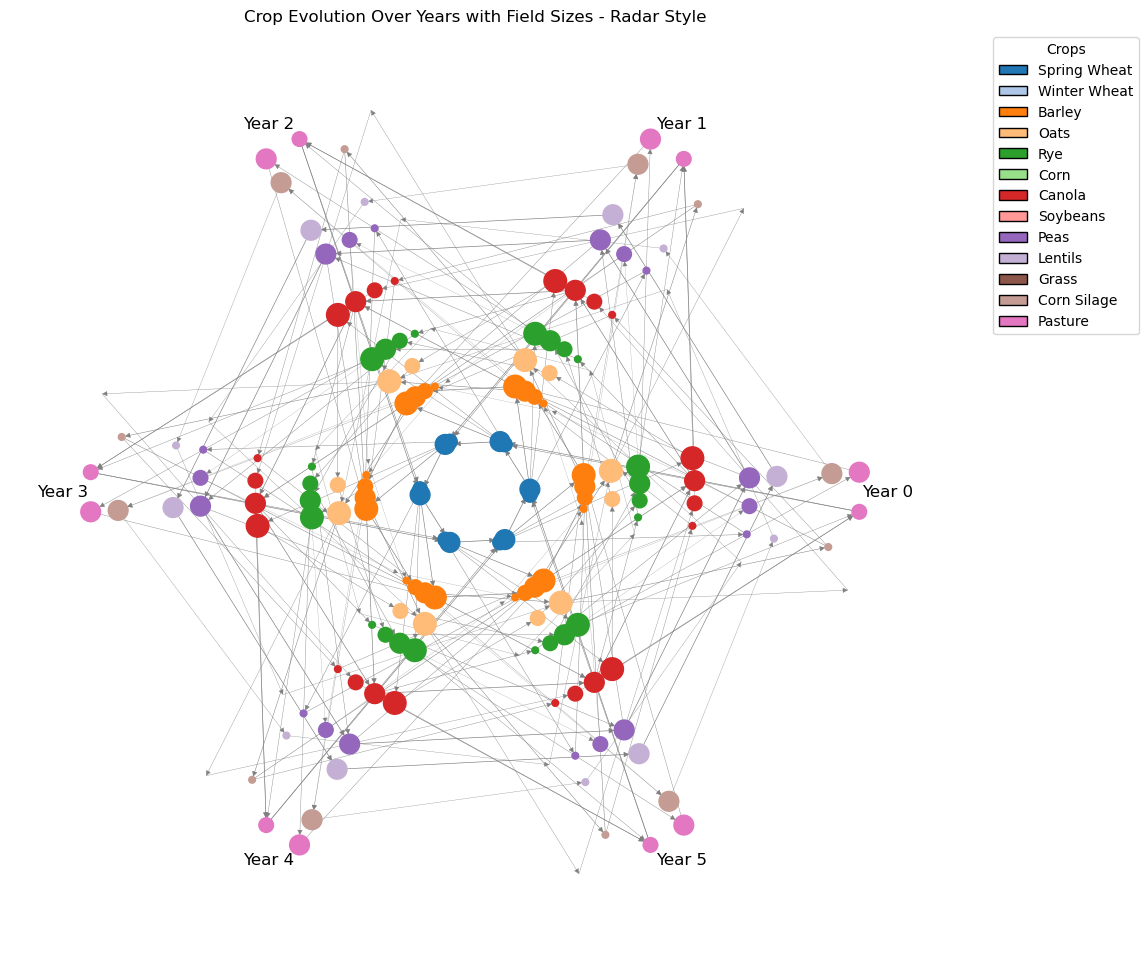

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

ccs_choice = CCSUID[0]
num_crops = len(Crops)
num_years = len(K)
radius_step = 20  # distance between crops along each year spoke

G = nx.DiGraph()
pos = {}

# Generate a distinct color for each crop

cmap = plt.get_cmap("tab20")  # up to 20 distinct colors
crop_colors = {crop: cmap(i % 20) for i, crop in enumerate(Crops)}

# -----------------------------

# Create positions: radial layout

# Years = circle vertices

# Crops = along spokes

# Field sizes = additional distance scaling

# -----------------------------

# -----------------------------

# Add edges between consecutive years for each crop and size

# -----------------------------

angle_offset = 0.1
r_offset = 20
size_offset = 0.8

for j, crop_j in enumerate(Crops):
    for s in S:
        for k, year in enumerate(K):
            for l, crop_l in enumerate(Crops):
                for r_idx in S:
                    src = f"{crop_j} (Year {year}, Size {Surface[s]})"
                    dst = f"{crop_l} (Year {year+1}, Size {Surface[r_idx]})" if k < num_years - 1 else f"{crop_l} (Year {0}, Size {Surface[r_idx]})"
                    weight = x[ccs_choice, j, s, l, r_idx, k].X * Surface[s]
                    if weight > 0.00001:
                        angle_s = 2 * np.pi * k / num_years + (s - len(S)/2) * angle_offset
                        angle_r = 2 * np.pi * (k + 1) / num_years + (r_idx - len(S)/2) * angle_offset
                        r_j = r_offset + (j + 1) * radius_step
                        r_l = r_offset + (l + 1) * radius_step
                        x_j = r_j * np.cos(angle_s)
                        y_j = r_j * np.sin(angle_s)
                        x_l = r_l * np.cos(angle_r)
                        y_l = r_l * np.sin(angle_r)
                        G.add_node(src, value=0, crop=crop_j, size=Surface[s])  # add node if not already present
                        G.add_node(dst, value=0, crop=crop_l, size=Surface[r_idx])
                        pos[src] = (x_j, y_j)
                        pos[dst] = (x_l, y_l)
                        G.add_edge(src, dst, weight=weight)

# -----------------------------

# Plot

# -----------------------------

plt.figure(figsize=(12, 12))
plt.axis("off")

# Node sizes scaled by value

node_sizes = [np.log(G.nodes[n]["size"]) * 50 for n in G.nodes()]  # scale factor

# Node colors based on crop

node_colors = [crop_colors[G.nodes[n]["crop"]] for n in G.nodes()]

# Edge widths scaled

edge_widths = [np.log(G[u][v]["weight"]) / 20 for u, v in G.edges()]

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    width=edge_widths,
    arrows=True,
    arrowsize=8
)

# -----------------------------

# Year labels around circle

# -----------------------------

for k, year in enumerate(K):
    angle = 2 * np.pi * k / num_years
    x_text = (num_crops + 2) * (radius_step) * np.cos(angle)
    y_text = (num_crops + 2) * (radius_step) * np.sin(angle)
    plt.text(x_text, y_text, f"Year {year}", ha="center", va="center", fontsize=12)

# -----------------------------

# Legend for crop colors

# -----------------------------

legend_elements = [Patch(facecolor=color, edgecolor='k', label=crop) for crop, color in crop_colors.items()]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Crops")

plt.title("Crop Evolution Over Years with Field Sizes - Radar Style")
plt.show()

/var/folders/yr/qhnlkgj13nn63_0zptp9g1400000gn/T/ipykernel_94758/204271306.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if float(C.loc[ccs]) == 0:
/var/folders/yr/qhnlkgj13nn63_0zptp9g1400000gn/T/ipykernel_94758/204271306.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cattle_usage = sum(x[ccs, j, s, 10, r, 0].X * Surface[s] * rho for j in J for s in S for r in S) / float(C.loc[ccs])


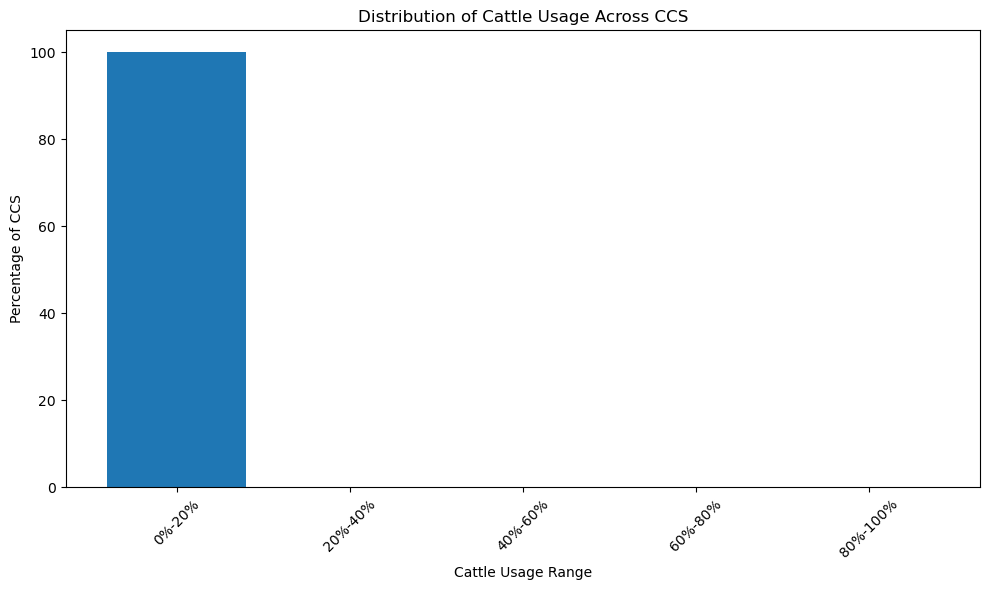

In [15]:
import matplotlib.pyplot as plt

# Report for all ccs the percentage of usage of cows in the rotation

# Range definition

range_perc = {
    "0%-20%": 0,
    "20%-40%": 0,
    "40%-60%": 0,
    "60%-80%": 0,
    "80%-100%": 0
}

no_cow = 0

for ccs in CCSUID:
    if float(C.loc[ccs]) == 0:
        no_cow += 1
        continue
    else:
        cattle_usage = sum(x[ccs, j, s, 10, r, 0].X * Surface[s] * rho for j in J for s in S for r in S) / float(C.loc[ccs])
        if cattle_usage <= 20:
            range_perc["0%-20%"] += 1
        elif cattle_usage <= 40:
            range_perc["20%-40%"] += 1
        elif cattle_usage <= 60:
            range_perc["40%-60%"] += 1
        elif cattle_usage <= 80:
            range_perc["60%-80%"] += 1
        else:
            range_perc["80%-100%"] += 1

for rg in range_perc.keys():
    range_perc[rg] = float(range_perc[rg]) / (len(CCSUID) - no_cow) * 100

plt.figure(figsize=(10, 6))

# Plot the bars
plt.bar(range_perc.keys(), range_perc.values())
plt.xlabel("Cattle Usage Range")
plt.ylabel("Percentage of CCS")
plt.title("Distribution of Cattle Usage Across CCS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
df = pd.read_csv("x_solution.csv")

# add the totcows column from C to df

df = df.merge(C, left_on="ccs", right_index=True, how="left")

grass_alocation = df[(df["j"] == 10) & (df['TOTCOW'] > 0)]["value"].sum()
pasture_alocation = df[(df["j"] == 12) & (df['TOTCOW'] > 0)]["value"].sum()

print(f"Grass allocation: {grass_alocation:.2f}")
print(f"Pasture allocation: {pasture_alocation:.2f}")

print(f"Grass/Pasture Ratio: {grass_alocation/(grass_alocation+pasture_alocation):.2f}")

Grass allocation: 82208.98
Pasture allocation: 567574.22
Grass/Pasture Ratio: 0.13


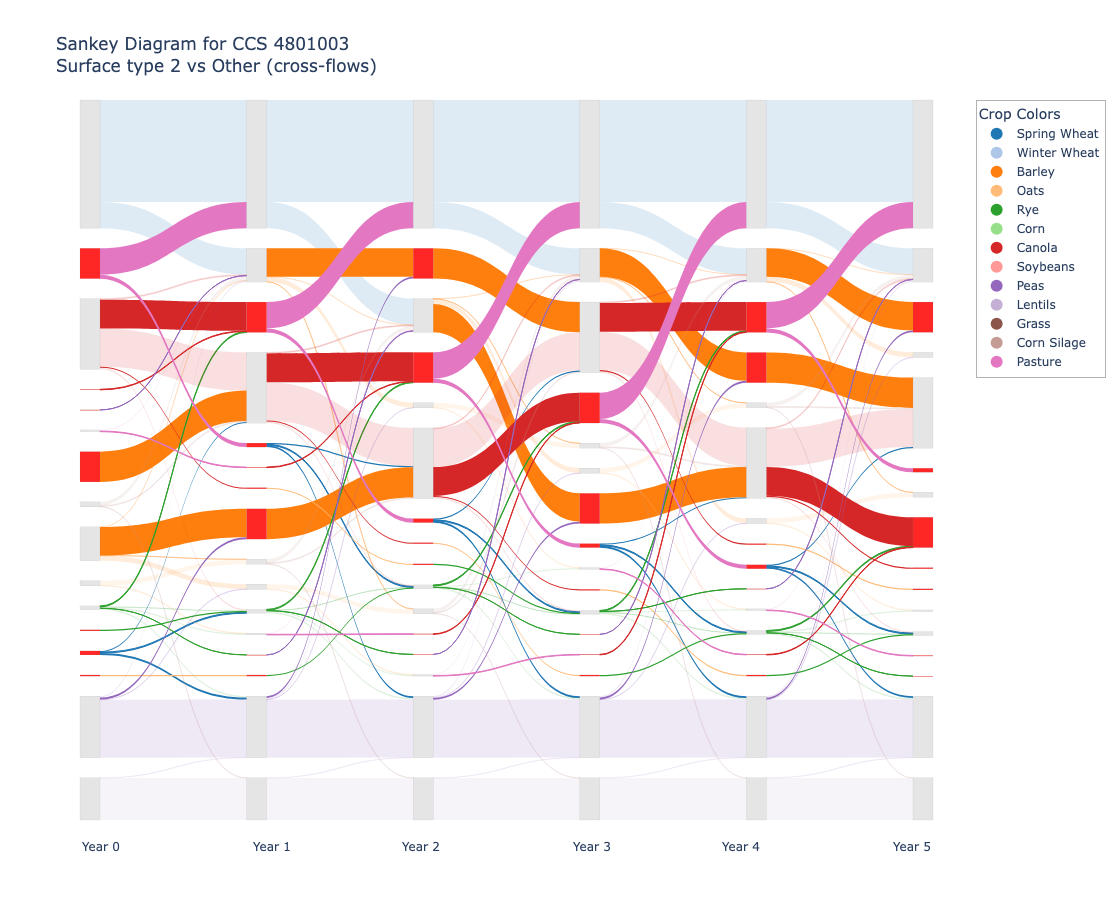

In [27]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

def build_sankey_focus_size(ccs_choice, s_focus, x, Crops, K, S):
    """
    Sankey diagram with:
    - Surface type 2 vs other
    - Cross flows allowed
    - Crop colors for type 2, grey for other
    - Years along x-axis
    """

    # -----------------------------
    # 1. COLOR MAPS
    # -----------------------------
    cmap = plt.get_cmap("tab20")
    crop_colors = {crop: cmap(i % 20) for i, crop in enumerate(Crops)}
    other_color = "rgba(180,180,180,0.35)"

    # -----------------------------
    # 2. BUILD NODES
    # -----------------------------
    nodes = []
    node_idx = {}
    node_x = []
    node_y = []
    idx = 0

    # Map years to x positions [0,1]
    year_pos = {k: i / (len(K)-1) for i, k in enumerate(K)}

    node_colors = []

    for k in K:
        for crop in Crops:
            # Type 2 node
            nodes.append("")
            node_idx[(crop, k, "type2")] = idx
            node_x.append(year_pos[k])
            node_y.append(None)  # vertical auto
            idx += 1
            node_colors.append("rgba(255,0,0,0.85)")

            # Other node
            nodes.append("")
            node_idx[(crop, k, "other")] = idx
            node_x.append(year_pos[k])
            node_y.append(None)
            idx += 1
            node_colors.append("rgba(180,180,180,0.35)")

    # -----------------------------
    # 3. BUILD LINKS
    # -----------------------------
    sources, targets, values, colors, labels = [], [], [], [], []

    for k_idx, k in enumerate(K[:-1]):
        next_k = K[k_idx + 1]

        for j, crop_j in enumerate(Crops):
            for l, crop_l in enumerate(Crops):
                for s_src in S:
                    for s_tgt in S:
                        flow = x[ccs_choice, j, s_src, l, s_tgt, k_idx].X * Surface[s_src]
                        if flow < 0.00001:
                            continue

                        src_cat = "type2" if s_src == s_focus else "other"
                        tgt_cat = "type2" if s_tgt == s_focus else "other"

                        sources.append(node_idx[(crop_j, k, src_cat)])
                        targets.append(node_idx[(crop_l, next_k, tgt_cat)])
                        values.append(flow)

                        # Link color
                        if src_cat == "type2" or tgt_cat == "type2":
                            r, g, b, a = crop_colors[crop_j]
                            colors.append(f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})")
                        else:
                            r, g, b, a = crop_colors[crop_j]
                            colors.append(f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.15)")

                        # Labels: only if type2 involved
                        if src_cat == "type2" or tgt_cat == "type2":
                            labels.append(f"{crop_j} → {crop_l} (type2 flow)")
                        else:
                            labels.append("")

    # -----------------------------
    # 4. CREATE FIGURE
    # -----------------------------
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            label=nodes,
            color=node_colors,
            line=dict(
                color="grey",          # border color
                width=0.1               # border thickness in pixels
            ),
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=colors,
            label=labels,
            hovertemplate="%{label}<br>Flow: %{value}<extra></extra>"
        )
    )])

    # -----------------------------
    # 5. CUSTOM LEGEND FOR CROPS
    # -----------------------------
    legend_traces = []
    for crop in Crops:
        r, g, b, a = crop_colors[crop]
        legend_traces.append(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=15, color=f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})"),
            showlegend=True,
            name=crop
        ))

    for trace in legend_traces:
        fig.add_trace(trace)

    # -----------------------------
    # 6. ANNOTATIONS FOR YEARS (X-AXIS)
    # -----------------------------
    annotations = []
    for k, x_pos in year_pos.items():
        annotations.append(dict(
            x=x_pos,
            y=-0.05,  # below nodes
            xref="paper",
            yref="paper",
            text=f"Year {k}",
            showarrow=False,
            font=dict(size=12)
        ))

    # -----------------------------
    # 7. LAYOUT
    # -----------------------------
    fig.update_layout(
        title=f"Sankey Diagram for CCS {ccs_choice}<br>Surface type 2 vs Other (cross-flows)",
        font_size=12,
        height=900,
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False),
        annotations=annotations,
        legend=dict(
            title="Crop Colors",
            x=1.05,
            y=1.0,
            bordercolor="rgba(0,0,0,0.3)",
            borderwidth=1,
            itemsizing="constant",
            font=dict(size=12)
        )
    )

    fig.show()


# ---------------------------
# Example Use
# ---------------------------
ccs_choice = CCSUID[0]
s_focus = S[2]  # surface type 2
build_sankey_focus_size(ccs_choice, s_focus, x, Crops, K, S)